# bin-to-res

This notebook tests the functionality of the bin_to_res core and is based on various PYNQ example notebooks.  

The overlay looks like 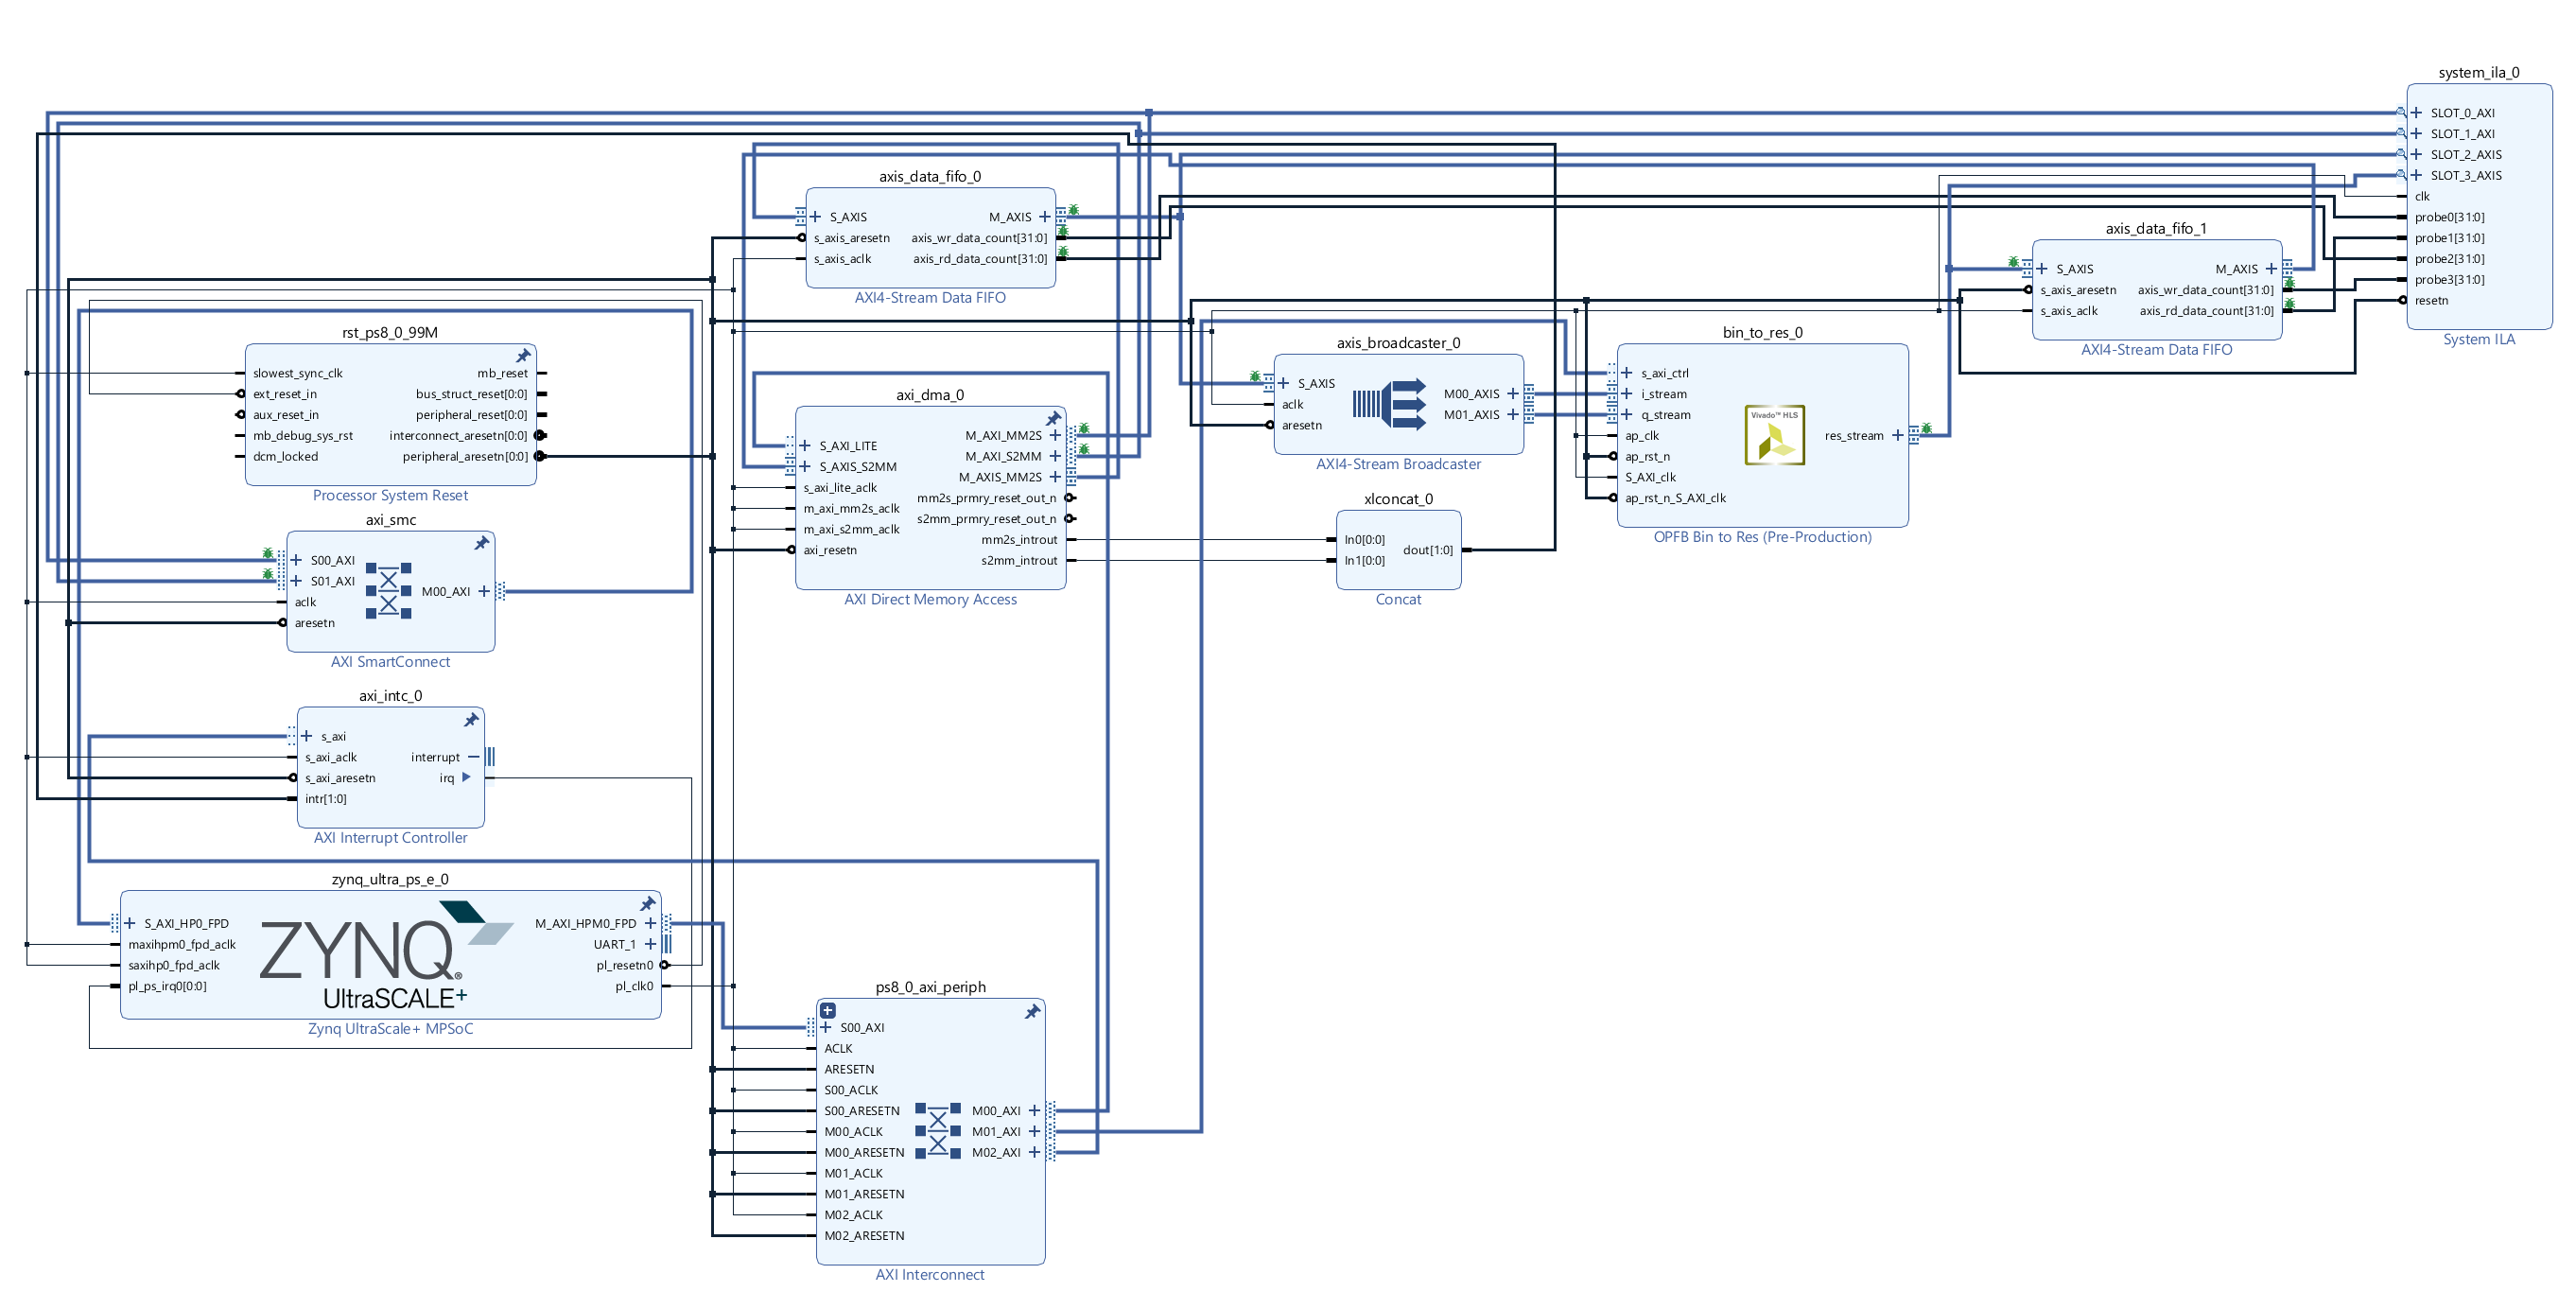

## 1. Instantiating an overlay
With the following overlay bundle present in the `overlays` folder, users can instantiate the overlay easily.

*  A bitstream file (\*.bit).
*  A tcl file (\*.tcl), or an hwh file (\*.hwh).
*  A python class (\*.py).

For example, an overlay called `base` can be loaded by:
```python
from pynq.overlays.base import BaseOverlay
overlay = BaseOverlay(SOME PATH)
```
Users can also use the absolute file path of the bitstream to instantiate the overlay.

In the following cell, we get the current bitstream loaded on PL, and try to download it multiple times. Then we can check the download timestamp for this overlay.

In [1]:
import numpy as np
from pynq import DefaultIP
class BinToResIP(DefaultIP):
    resmap_addr = 0x1000
    def __init__(self, description):
        """
        0x1fff : Memory 'data_V' (256 * 96b)
        Word 4n   : bit [31:0] - data_V[n][31: 0]
        Word 4n+1 : bit [31:0] - data_V[n][63:32]
        Word 4n+2 : bit [31:0] - data_V[n][95:64]
        Word 4n+3 : bit [31:0] - reserved
        """
        super().__init__(description=description)

    bindto = ['MazinLab:mkidgen3:bin_to_res:0.4']

    @staticmethod
    def _checkgroup(group_ndx):
        if group_ndx<0 or group_ndx>255:
            raise ValueError('group_ndx must be in [0,255]')

    def read_group(self, group_ndx):
        self._checkgroup(group_ndx)
        g=0
        vals=[self.read(self.resmap_addr+16*group_ndx+4*i) for i in range(3)]
        for i,v in enumerate(vals):
            #print(format(v,'032b'))
            g|=v<<(32*i)
        #print('H-'+format(g,'096b')+'-L')
        return [((g>>(12*j))&0xfff) for j in range(8)]

    def write_group(self, group_ndx, group):
        self._checkgroup(group_ndx)
        if len(group)!=8:
            raise ValueError('len(group)!=8')
        bits=0
        for i,g in enumerate(group):
            bits|=(int(g)&0xfff)<<(12*i)
        #print('H-'+format(bits,'096b')+'-L')
        data = bits.to_bytes(12, 'little', signed=False)
        #print([format(d,'08b') for d in data])
        #print(len(data))
        self.write(self.resmap_addr+16*group_ndx, data)

    def bin(self, res):
        """ The mapping for resonator i is 12 bits and will require reading 1 or 2 32 bit word
        n=i//8 j=(i%8)*12//32 
        """
        return self.read_group(res//8)[res%8]

    @property
    def bins(self):
        return [v for g in range(256) for v in self.read_group(g)]

    @bins.setter
    def bins(self, bins):
        if len(bins)!=2048:
            raise ValueError('len(bins)!=2048')
        if min(bins)<0 or max(bins)>4095:
            raise ValueError('Bin values must be in [0,4095]')
        for i in range(256):
            self.write_group(i, bins[i*8:i*8+8])
            
def dma_status(dma):
    #dma.recvchannel.idle,dma.sendchannel.idle
    msg=("DMA:\n"
         " MM2s\n"
         f" Idle:{dma.sendchannel.idle}\n"
         f" MM2S_DMASR (status):{hex(dma.mmio.read(4))}\n"
         f" MM2S_SA (ptr) :{hex(dma.mmio.read(24))}\n"
         f" MM2S_LENGTH (len):{dma.mmio.read(40)}\n"
         " S2MM\n"
         f" Idle:{dma.recvchannel.idle}\n"
         f" S2MM_DMASR (status):{hex(dma.mmio.read(52))}\n"
         f" S2MM_DA (ptr) :{hex(dma.mmio.read(72))}\n"
         f" S2MM_LENGTH (len):{dma.mmio.read(88)}")
    print(msg)

In [2]:
from pynq import PL
from pynq import Overlay
from pynq import Xlnk
# input_buffer = xlnk.cma_array(shape=(n_bin,), dtype=np.uint16)
# output_buffer = xlnk.cma_array(shape=(n_res,), dtype=np.uint32)
from pynq import allocate

n_res = 2048
n_bin = 4096
ol = overlay = Overlay('/home/xilinx/overlayfiles/test_bin_to_res/test_reschan.bit')
ol.download()
print(f"PL Bitfile: {PL.bitfile_name}\n  {PL.timestamp}\n"
      f"Overlay timestamp: {ol.timestamp}  Loaded: {ol.is_loaded()}")

PL Bitfile: /home/xilinx/overlayfiles/test_bin_to_res/test_reschan.bit
  2020/2/13 22:39:20 +549830
Overlay timestamp: 2020/2/13 22:39:20 +549830  Loaded: True


## 3. Overlay Exploration


In [3]:
overlay.ip_dict.keys()

dict_keys(['axi_dma_0', 'bin_to_res_0', 'axi_intc_0'])

In [4]:
overlay.ip_dict

{'axi_dma_0': {'addr_range': 65536,
  'device': <pynq.pl_server.device.XlnkDevice at 0x7f78061240>,
  'driver': pynq.lib.dma.DMA,
  'fullpath': 'axi_dma_0',
  'gpio': {},
  'interrupts': {'mm2s_introut': {'controller': 'axi_intc_0',
    'fullpath': 'axi_dma_0/mm2s_introut',
    'index': 0},
   's2mm_introut': {'controller': 'axi_intc_0',
    'fullpath': 'axi_dma_0/s2mm_introut',
    'index': 1}},
  'mem_id': 'S_AXI_LITE',
  'parameters': {'C_BASEADDR': '0xA0000000',
   'C_DLYTMR_RESOLUTION': '125',
   'C_ENABLE_MULTI_CHANNEL': '0',
   'C_FAMILY': 'zynquplus',
   'C_HIGHADDR': '0xA000FFFF',
   'C_INCLUDE_MM2S': '1',
   'C_INCLUDE_MM2S_DRE': '0',
   'C_INCLUDE_MM2S_SF': '1',
   'C_INCLUDE_S2MM': '1',
   'C_INCLUDE_S2MM_DRE': '0',
   'C_INCLUDE_S2MM_SF': '1',
   'C_INCLUDE_SG': '0',
   'C_INCREASE_THROUGHPUT': '0',
   'C_MICRO_DMA': '0',
   'C_MM2S_BURST_SIZE': '128',
   'C_M_AXIS_MM2S_CNTRL_TDATA_WIDTH': '32',
   'C_M_AXIS_MM2S_TDATA_WIDTH': '256',
   'C_M_AXI_MM2S_ADDR_WIDTH': '32',
   

In [5]:
bin2res = ol.bin_to_res_0
dma = ol.axi_dma_0

Look at the register map of the bin to res core, the large resmap array isn't directly supported by PYNQ so the warning is expected.

In [6]:
bin2res.register_map

/usr/local/lib/python3.6/dist-packages/pynq/registers.py:422: UserWarning: Unsupported register size 4096 for register Memory_resmap_V
  v[2], k


RegisterMap {
  align_V = Register(align_V=0, RESERVED=0)
}

In [7]:
bin2res.register_map.align_V.align_V

0

### Reading and writing DMA

Prepare memory for sending and recieving from the core.

In [8]:
input_buffer = allocate(shape=(n_bin,), dtype=np.uint16)
output_buffer16 = allocate(shape=(n_res*2,), dtype=np.uint16)

In [9]:
def show_out(buf, n=30):
    if buf.dtype==np.uint16:
        for i in range(0,n*2,16): 
            for j in range(8):
                ndx=j+i
                if (ndx%8)==0: print(f'i={ndx//2}')
                print(f"   {ndx-8*i//16}: {buf[ndx]:4},{buf[ndx+8]:4}")
show_out(output_buffer16, n=16)

i=0
   0:    0,   0
   1:    0,   0
   2:    0,   0
   3:    0,   0
   4:    0,   0
   5:    0,   0
   6:    0,   0
   7:    0,   0
i=8
   8:    0,   0
   9:    0,   0
   10:    0,   0
   11:    0,   0
   12:    0,   0
   13:    0,   0
   14:    0,   0
   15:    0,   0


### Check the status of the DMA

The bin to resonator packets are $16kB = 256~cycles \cdot 2 \cdot256~bits/cycle$, the testbench duplicates the I stream to create Q so they the MM2S write size is half that.

The resonator packets are $8kB = 256~cycles \cdot \cdot256~bits/cycle$.

In [10]:
print(dma.mmio.base_addr,dma.mmio.length,dma.buffer_max_size)
for k,v in dma._registers.items():
    print(f"{k}: {v['address_offset']}  {v['access']}")

2684354560 65536 16384
MM2S_DMACR: 0  read-write
MM2S_DMASR: 4  read-write
MM2S_CURDESC: 8  read-write
MM2S_CURDESC_MSB: 12  read-write
MM2S_TAILDESC: 16  read-write
MM2S_TAILDESC_MSB: 20  read-write
MM2S_SA: 24  read-write
MM2S_SA_MSB: 28  read-write
MM2S_LENGTH: 40  read-write
SG_CTL: 44  read-write
S2MM_DMACR: 48  read-write
S2MM_DMASR: 52  read-write
S2MM_CURDESC: 56  read-write
S2MM_CURDESC_MSB: 60  read-write
S2MM_TAILDESC: 64  read-write
S2MM_TAILDESC_MSB: 68  read-write
S2MM_DA: 72  read-write
S2MM_DA_MSB: 76  read-write
S2MM_LENGTH: 88  read-write


In [11]:
bins=np.arange(2048)
bins[:]=999
bins[:5]=np.arange(5)
bins[-1]=4095
bin2res.bins=bins

### Configure the mapping

2048 uint12 bin addresses

In [12]:
print('Writing mapping...')
bins=np.arange(2048)
bins[-1]=4095
bin2res.bins=bins
print('Reading group 0',bin2res.read_group(0))
print('Reading group 255',bin2res.read_group(255))

Writing mapping...
Reading group 0 [0, 1, 2, 3, 4, 5, 6, 7]
Reading group 255 [2040, 2041, 2042, 2043, 2044, 2045, 2046, 4095]


### Generate and feed a stream

4096 16 bit numbers, note that operations like input_buffer[5:]=999 will kill the kernel (at least sometimes)!

Send it twice to ensure we drive the tlast all the way through the core (latency is >1)

In [13]:
input_buffer[:]=np.arange(4096)

In [14]:
print('Initial DMA Status')
dma.sendchannel.transfer(input_buffer)
dma.sendchannel.wait()
dma.sendchannel.transfer(input_buffer)
dma.sendchannel.wait()

In [15]:
dma.recvchannel.transfer(output_buffer16)
dma.sendchannel.wait()
print('After receive')

### Look at the results

It seems the HLS core packs an array defined as complex<ap_fixed<16>> x[8] as real0 real1...real7 imag0...imag7, I've not found any documentation of this.

In [17]:
print(f"Replay misalignment: {bin2res.register_map.align_V.align_V}")
show_out(output_buffer16, n=32)
resIQs=np.transpose(output_buffer16.reshape((2*n_res//16,2,8)),(0,2,1))

Replay misalignment: 0
i=0
   0:    0,   0
   1:    1,   1
   2:    2,   2
   3:    3,   3
   4:    4,   4
   5:    5,   5
   6:    6,   6
   7:    7,   7
i=8
   8:    8,   8
   9:    9,   9
   10:   10,  10
   11:   11,  11
   12:   12,  12
   13:   13,  13
   14:   14,  14
   15:   15,  15
i=16
   16:   16,  16
   17:   17,  17
   18:   18,  18
   19:   19,  19
   20:   20,  20
   21:   21,  21
   22:   22,  22
   23:   23,  23
i=24
   24:   24,  24
   25:   25,  25
   26:   26,  26
   27:   27,  27
   28:   28,  28
   29:   29,  29
   30:   30,  30
   31:   31,  31
